# Imports & upload Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
# epochs = 30
epochs = 2

In [3]:
files = glob(r'Datasets\Car-Bike-Dataset\*\*.*')

len(files)

4000

In [4]:
label = [file.split('\\')[2] for file in files]

In [5]:
set(label)

{'Bike', 'Car'}

In [6]:
df = pd.DataFrame({'file_path' : files,
                   'label': label})
df.head()

,file_path,label
0,Datasets\Car-Bike-Dataset\Bike\Bike (1).jpeg,Bike
1,Datasets\Car-Bike-Dataset\Bike\Bike (1).jpg,Bike
2,Datasets\Car-Bike-Dataset\Bike\Bike (1).png,Bike
3,Datasets\Car-Bike-Dataset\Bike\Bike (10).jpeg,Bike
4,Datasets\Car-Bike-Dataset\Bike\Bike (10).jpg,Bike


In [7]:
df['file_path'].str.split('.').apply(lambda x : x[-1]).value_counts()

0       jpeg
1        jpg
2        png
3       jpeg
4        jpg
        ... 
3995    jpeg
3996    jpeg
3997    jpeg
3998    jpeg
3999    jpeg
Name: file_path, Length: 4000, dtype: object

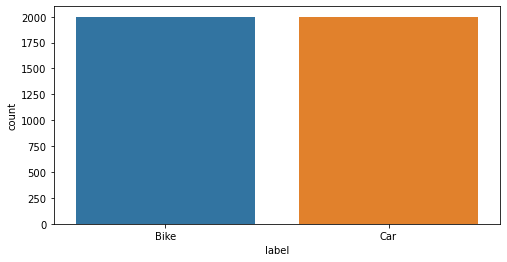

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x =df['label'])
plt.show()

In [9]:
indces = []
for file in df['file_path']:
    try:
        plt.imread(file).shape
    except:
        print(df[df['file_path'] == file].index)
        df.drop(df[df['file_path'] == file].index,inplace= True)


Int64Index([5], dtype='int64')
Int64Index([251], dtype='int64')
Int64Index([495], dtype='int64')
Int64Index([853], dtype='int64')
Int64Index([916], dtype='int64')
Int64Index([1447], dtype='int64')
Int64Index([1693], dtype='int64')
Int64Index([3310], dtype='int64')


# Split Data

In [10]:
df_train , df_val =train_test_split(
    df, test_size=0.2,
    random_state=1, stratify=df['label']
)

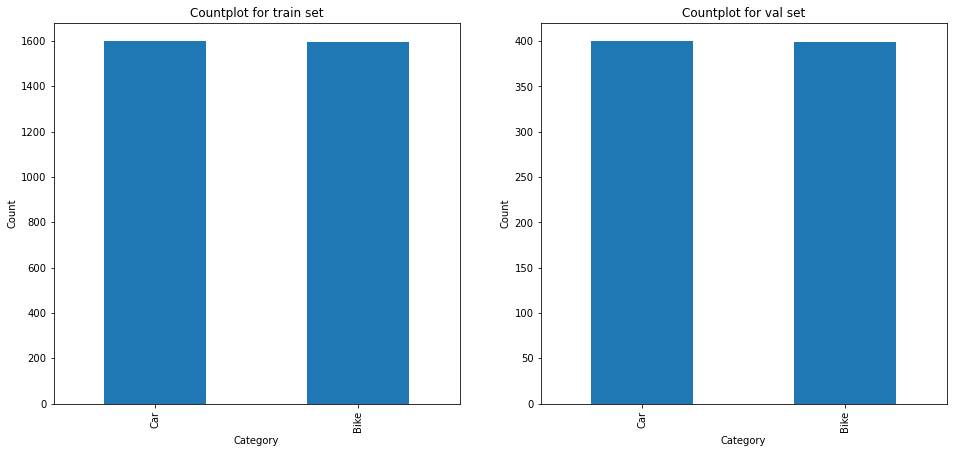

In [11]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
df_train['label'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
df_val['label'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

# Data Generation

In [12]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

In [13]:
train_set = train_gen.flow_from_dataframe(
    df_train, 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    df_val , 
    x_col='file_path',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)



Found 3193 validated image filenames belonging to 2 classes.
Found 799 validated image filenames belonging to 2 classes.


In [14]:
class_dict = {v:k for k,v in train_set.class_indices.items()}

NUM_CLASS = len(class_dict)
class_dict

{0: 'Bike', 1: 'Car'}

# Visualize Our Data 

In [15]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

C:\Users\mmmmmm\anaconda3\envs\Deeplearning\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


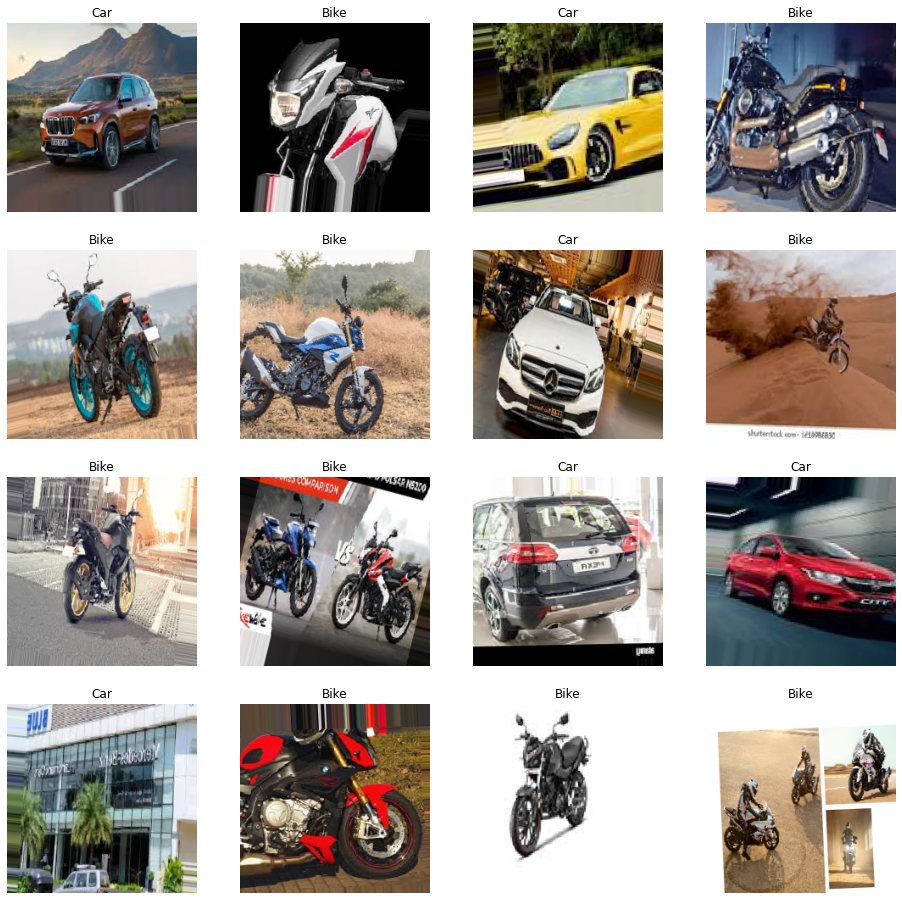

In [16]:
see_examples(train_set)

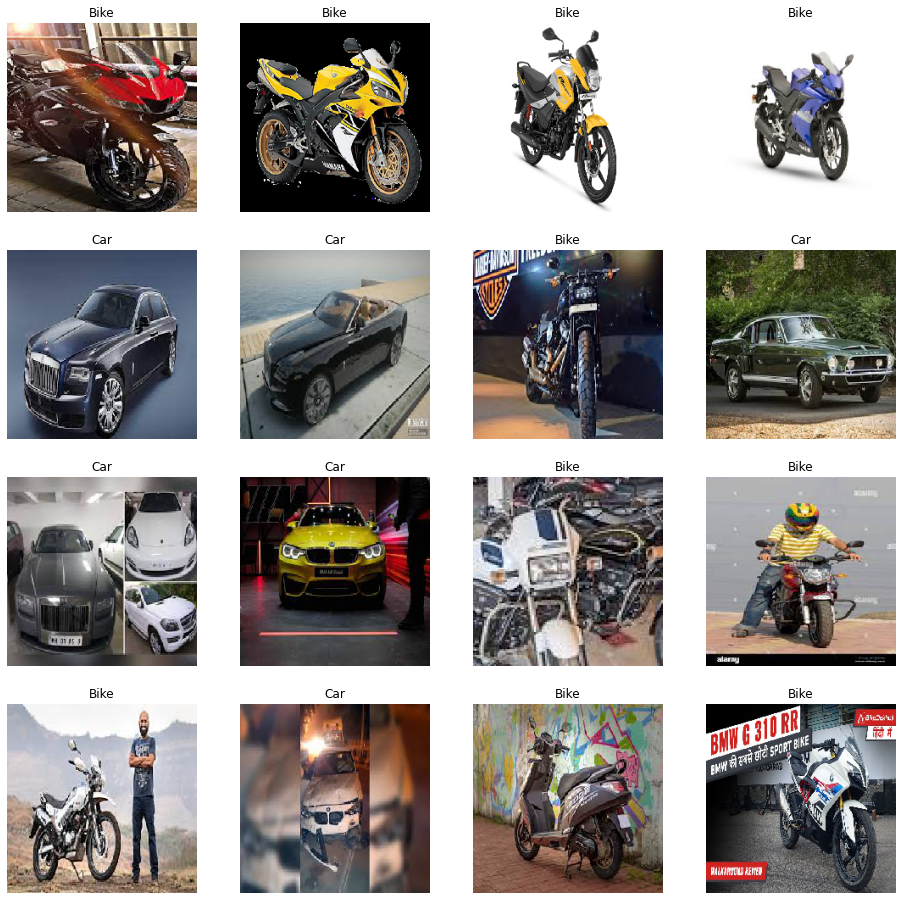

In [17]:
see_examples(val_set)

# Build Model

In [18]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 

In [20]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [22]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [23]:
history = model.fit(train_set,epochs=epochs, batch_size=BATCH_SIZE,
                  validation_data=val_set,callbacks= callbacks
                             )

Epoch 1/2
50/50 [==============================] - 292s 6s/step - loss: 0.1122 - categorical_accuracy: 0.9612 - f1_score: 0.9612 - precision: 0.9612 - recall: 0.9612 - val_loss: 0.4751 - val_categorical_accuracy: 0.9512 - val_f1_score: 0.9511 - val_precision: 0.9512 - val_recall: 0.9512 - lr: 0.0010
Epoch 2/2
50/50 [==============================] - 274s 5s/step - loss: 0.0272 - categorical_accuracy: 0.9906 - f1_score: 0.9906 - precision: 0.9906 - recall: 0.9906 - val_loss: 0.0393 - val_categorical_accuracy: 0.9912 - val_f1_score: 0.9912 - val_precision: 0.9912 - val_recall: 0.9912 - lr: 0.0010


In [24]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,categorical_accuracy,f1_score,precision,recall,val_loss,val_categorical_accuracy,val_f1_score,val_precision,val_recall,lr
0,0.112159,0.961165,"[0.9615623, 0.9607595]",0.961165,0.961165,0.475143,0.951189,"[0.9486166, 0.9535161]",0.951189,0.951189,0.001
1,0.027220,0.990604,"[0.9906074, 0.99060154]",0.990604,0.990604,0.039291,0.991239,"[0.99115044, 0.9913259]",0.991239,0.991239,0.001


In [25]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

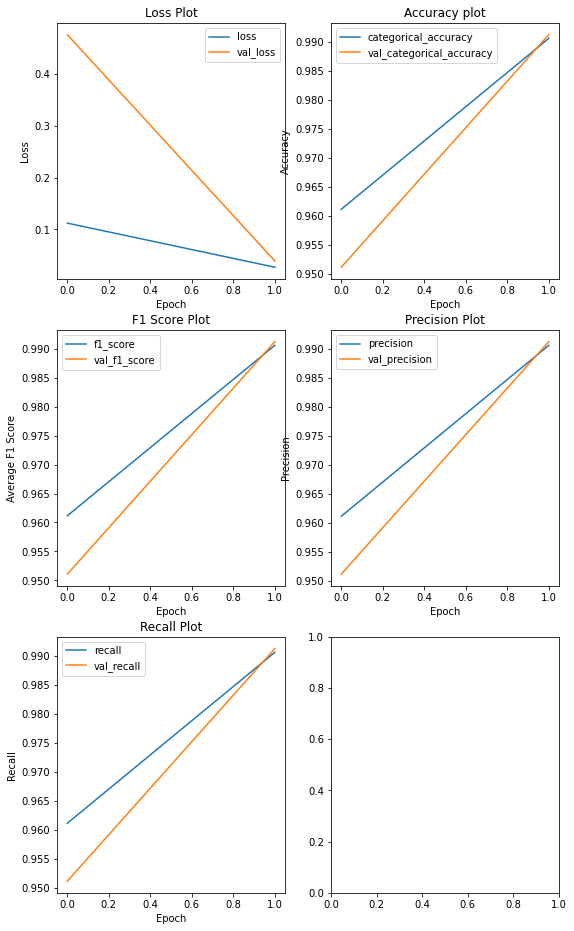

In [26]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [27]:
best_model = load_model('best_model.h5')

In [28]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(val_set)

13/13 [==============================] - 48s 3s/step - loss: 0.0393 - categorical_accuracy: 0.9912 - f1_score: 0.9912 - precision: 0.9912 - recall: 0.9912
